In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import s2spy.time
import s2spy.rgdr

Note that lat/lon conversion is not required as long as the values are in degrees (with 0 degrees latitude being the equator, and 0 degrees longitude the prime meridian). The haversine equation in sklearn uses radians as input, 

In [2]:
field = xr.open_dataset(r'C:\Users\BartSchilperoort\temp\rgdr_data\sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(r'C:\Users\BartSchilperoort\temp\rgdr_data\tf5_nc5_dendo_80d77.nc')

cal = s2spy.time.AdventCalendar((8, 31), freq = "30d")
field_resampled = cal.resample(field)
target_resampled = cal.resample(target)

In [3]:
target_timeseries = target_resampled.sel(cluster=3).ts

In [4]:
field_resampled

<xarray.Dataset>
Dimensions:      (anchor_year: 39, i_interval: 12, latitude: 5, longitude: 13)
Coordinates:
    index        (anchor_year, i_interval) int64 0 1 2 3 4 ... 464 465 466 467
    interval     (anchor_year, i_interval) object (1980-08-01, 1980-08-31] .....
  * latitude     (latitude) float64 47.5 42.5 37.5 32.5 27.5
  * longitude    (longitude) float64 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * anchor_year  (anchor_year) int64 1980 1981 1982 1983 ... 2015 2016 2017 2018
  * i_interval   (i_interval) int64 0 1 2 3 4 5 6 7 8 9 10 11
    target       (i_interval) bool True False False False ... False False False
Data variables:
    sst          (anchor_year, i_interval, latitude, longitude) float64 284.2...

In [5]:
field_resampled['corr'], field_resampled['p_val'] = \
    s2spy.rgdr._map_analysis.correlation(field_resampled.sst, target_timeseries.sel(i_interval=0),
                                         corr_dim='anchor_year')

Plot `lag 1` correlation map:

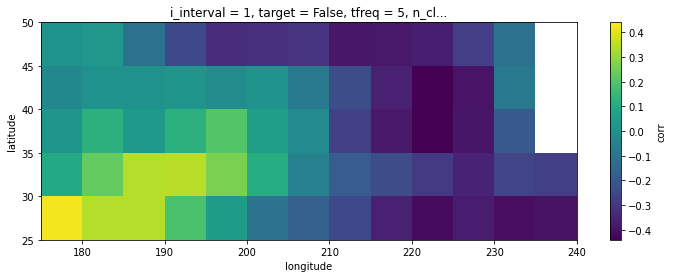

In [6]:
#field_resampled.corr.sel(i_interval=20).plot()
field_resampled.corr.sel(i_interval=1).plot(cmap='viridis', size=4, aspect=3)

Cluster with `DBSCAN`

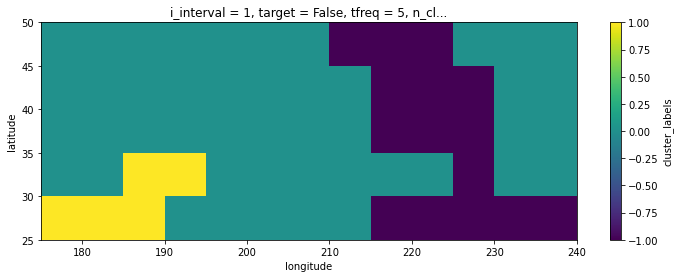

In [7]:
import s2spy.rgdr

clusters = s2spy.rgdr._map_regions.dbscan(field_resampled.sel(i_interval=1),
                                          eps_km=600, alpha=0.04)

clusters.cluster_labels.plot(cmap='viridis', size=4, aspect=3)


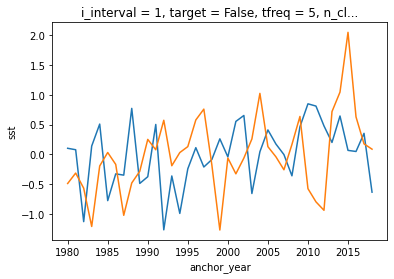

In [8]:
clustered_data = s2spy.rgdr._map_regions.cluster(field_resampled.sel(i_interval=1),
                                                 eps_km=600, alpha=0.04)

clustered_data['sst'] -= clustered_data['sst'].mean(dim='anchor_year')

clustered_data['sst'].sel(cluster_labels=1).plot.line(x='anchor_year')
clustered_data['sst'].sel(cluster_labels=-1).plot.line(x='anchor_year')


In [9]:
n_intervals = 12
cdata = [0]*n_intervals
for interval in range(n_intervals):
    cdata[interval] = s2spy.rgdr._map_regions.cluster(
        field_resampled.sel(i_interval=interval), eps_km=600, alpha=0.05)



In [10]:
[c.cluster_labels.values for c in cdata]

[array([-1.,  0.]),
 array([-2., -1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-1.,  0.,  1.]),
 array([-2., -1.,  0.]),
 array([-2., -1.,  0.]),
 array([-3., -2., -1.,  0.]),
 array([-1.,  0.]),
 array([-1.,  0.]),
 array([-1.,  0.]),
 array([0.]),
 array([-1.,  0.])]